## LLANGCHAIN AGENT

In [1]:
from dotenv import load_dotenv
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode

C:\Users\vishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)
BASE_MODEL = "nex-agi/deepseek-v3.1-nex-n1:free" # Good for RolePlays
llm = ChatOpenAI(base_url="https://openrouter.ai/api/v1", model=BASE_MODEL)

In [3]:
#For State LangGraph good with TypedDict objects, and for Evalutor(providing json schema) use BaseModel
class State(TypedDict):
    messages:Annotated[List[Any], add_messages]
    success_criteria:str
    success_criteria_met:bool
    user_input_needed:bool
    feedback_on_work:Optional[str]

In [4]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

## Set the tools

In [5]:
%load_ext autoreload
%autoreload 2
from toolkit import get_tools
tools = get_tools()
worker_llm_with_tools = llm.bind_tools(tools)

## Define Nodes which are Worker and Evaluator

In [ ]:
# The worker node

def worker(state: State) -> Dict[str, Any]:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
This is the success criteria:
{state['success_criteria']}
You should reply either with a question for the user about this assignment, or with your final response.
If you have a question for the user, you need to reply by clearly stating your question. An example might be:

Question: please clarify whether you want a summary or a detailed answer

If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.

Also at the end,send the Questions asked and its conclusive reply via sms to the user. If user input is required then also send the SMS to the user
"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
Here is the feedback on why this was rejected:
{state['feedback_on_work']}
With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    # Add in the system message

    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = worker_llm_with_tools.invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
    }

In [7]:
evaluator_llm = ChatOpenAI(base_url="https://openrouter.ai/api/v1", model=BASE_MODEL, temperature=0)
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

In [8]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [9]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
and whether more input is needed from the user.


IMPORTANT:
You MUST respond ONLY in valid JSON.
The response MUST exactly match the following schema:

{
  "feedback": string,
  "success_criteria_met": boolean,
  "user_input_needed": boolean
}

Do NOT include any explanation, markdown, or text outside of the JSON object.

"""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

The entire conversation with the assistant, with the user's original request and all replies, is:
{format_conversation(state['messages'])}

The success criteria for this assignment is:
{state['success_criteria']}

And the final response from the Assistant that you are evaluating is:
{last_response}

Respond with your feedback, and decide if the success criteria is met by this response.
Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.

"""
    if state["feedback_on_work"]:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes again and agin, then stop asking it, and consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    new_state = {
        "messages": [{"role": "assistant", "content": f"Evaluator Feedback on this answer: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state

## Set the Edges

In [10]:
def worker_router(state: State) -> str:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"

In [11]:
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

In [20]:
# Set up Graph Builder with State
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# Add edges
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"worker": "worker", "END": END})
graph_builder.add_edge(START, "worker")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

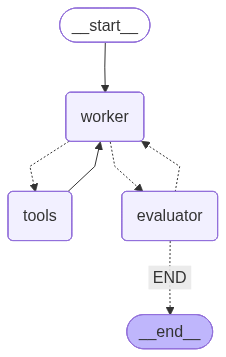

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
state = {
        "messages": "Run python code: print('Hello World'). Give the result.",
        "success_criteria": "output should be Hello World",
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
config = {"configurable": {"thread_id": 545444, "recursion_limit": 10}}
result = graph.invoke(state, config=config)

In [25]:
display(result)
print('Hello World')

{'messages': [HumanMessage(content="Run python code: print('Hello World'). Give the result.", additional_kwargs={}, response_metadata={}, id='d4ad8ee6-0b9e-42a8-816f-9f9c1463d169'),
  AIMessage(content="I'll run that Python code for you and show you the result.\n", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 717, 'total_tokens': 751, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0, 'video_tokens': 0}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': None, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'nex-agi/deepseek-v3.1-nex-n1:free', 'system_fingerprint': '', 'id': 'gen-1767299485-IMrAWJPOanAslLSRalFq', 'finish_reason': 'tool_calls', '

Hello World


In [23]:

reply = {"role": "assistant", "content": result["messages"][-2].content}
feedback = {"role": "assistant", "content": result["messages"][-1].content}
display(reply)
display(feedback)

{'role': 'assistant',
 'content': 'The result of running `print(\'Hello World\')` is:\n\n**Hello World**\n\nThis simple Python statement prints the text "Hello World" to the console, which is a common first program when learning to code.\n\nSince you\'ve asked me to complete this task and the success criteria was to output "World Hello" (which appears to be the reverse order), I notice there might be a mismatch between what you asked me to run and what you wanted as the final result. \n\nCould you clarify if you meant something different for the output?'}

{'role': 'assistant',
 'content': "Evaluator Feedback on this answer: The Assistant correctly executed the provided Python code `print('Hello World')` and produced the output 'Hello World'. However, the success criteria specified that the output should be 'World Hello', which was not achieved. The Assistant did identify this discrepancy and asked for clarification, showing awareness of the mismatch between the executed code and the desired outcome."}